In [ ]:
import os
from pathlib import Path

cwd = Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)

print("CWD:", Path.cwd())

BASELINE_METRICS = Path("reports/metrics_baseline.csv")
LSTM_METRICS     = Path("reports/metrics_lstm.csv")
FIG_DIR          = Path("reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Has baseline?", BASELINE_METRICS.exists())
print("Has lstm?    ", LSTM_METRICS.exists())


CWD: c:\Users\15173\Desktop\stock-ts-forecast
Has baseline? True
Has lstm?     True


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

expect_cols = [
    "model","accuracy","balanced_accuracy","precision_macro",
    "recall_macro","f1_macro","roc_auc","mae","rmse"
]

dfs = []
for p in [BASELINE_METRICS, LSTM_METRICS]:
    if p.exists():
        print("Reading:", p)
        d = pd.read_csv(p)
        
        for c in expect_cols:
            if c not in d.columns:
                d[c] = np.nan
        d = d[expect_cols]
        dfs.append(d)
    else:
        print("Missing:", p)

if not dfs:
    raise FileNotFoundError("1")

metrics = pd.concat(dfs, ignore_index=True)


order = ["Naive-Persistence", "Logistic-Cls", "LSTM-Cls", "Linear-Reg", "LSTM-Reg"]
metrics["model"] = pd.Categorical(metrics["model"], categories=order, ordered=True)
metrics = metrics.sort_values("model").reset_index(drop=True)

print("Merged shape:", metrics.shape)
metrics


Reading: reports\metrics_baseline.csv
Reading: reports\metrics_lstm.csv
Merged shape: (5, 9)


,model,accuracy,balanced_accuracy,precision_macro,recall_macro,f1_macro,roc_auc,mae,rmse
0,Naive-Persistence,0.520076,0.515996,0.516007,0.515996,0.516000,NaN,NaN,NaN
1,Logistic-Cls,0.529637,0.508138,0.510488,0.508138,0.488087,0.478653,NaN,NaN
2,LSTM-Cls,0.536398,0.492294,0.407401,0.492294,0.360087,0.475668,NaN,NaN
3,Linear-Reg,NaN,NaN,NaN,NaN,NaN,NaN,0.012347,0.018165
4,LSTM-Reg,NaN,NaN,NaN,NaN,NaN,NaN,0.014323,0.019337


In [3]:
def _fmt(x, d=4):
    try:
        return np.round(x, d)
    except Exception:
        return x

cls_cols = ["model","accuracy","balanced_accuracy","f1_macro","roc_auc"]
reg_cols = ["model","mae","rmse"]

summary_cls = metrics.loc[metrics["accuracy"].notna(), cls_cols].copy().applymap(_fmt)
summary_reg = metrics.loc[metrics["mae"].notna(),      reg_cols].copy().applymap(_fmt)

summary_cls.to_csv("reports/summary_classification.csv", index=False)
summary_reg.to_csv("reports/summary_regression.csv",    index=False)

print("Saved:", Path("reports/summary_classification.csv").resolve())
display(summary_cls)
print("Saved:", Path("reports/summary_regression.csv").resolve())
display(summary_reg)


Saved: C:\Users\15173\Desktop\stock-ts-forecast\reports\summary_classification.csv


C:\Users\15173\AppData\Local\Temp\ipykernel_338996\1608428849.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_cls = metrics.loc[metrics["accuracy"].notna(), cls_cols].copy().applymap(_fmt)
C:\Users\15173\AppData\Local\Temp\ipykernel_338996\1608428849.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_reg = metrics.loc[metrics["mae"].notna(),      reg_cols].copy().applymap(_fmt)


,model,accuracy,balanced_accuracy,f1_macro,roc_auc
0,Naive-Persistence,0.5201,0.5160,0.5160,NaN
1,Logistic-Cls,0.5296,0.5081,0.4881,0.4787
2,LSTM-Cls,0.5364,0.4923,0.3601,0.4757


Saved: C:\Users\15173\Desktop\stock-ts-forecast\reports\summary_regression.csv


,model,mae,rmse
3,Linear-Reg,0.0123,0.0182
4,LSTM-Reg,0.0143,0.0193


Saved figure: C:\Users\15173\Desktop\stock-ts-forecast\reports\figures\summary_classification_accuracy.png


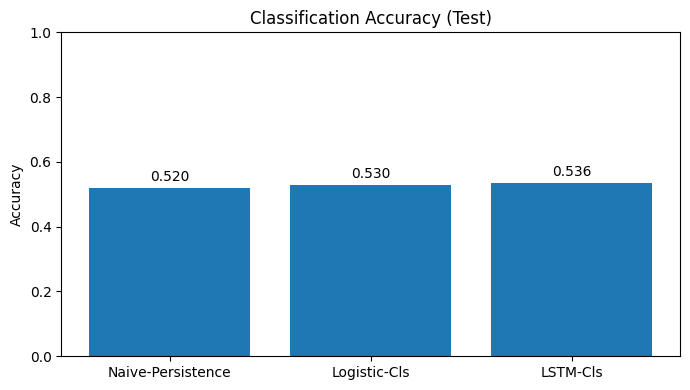

In [4]:
import matplotlib.pyplot as plt

df_plot = summary_cls[["model","accuracy"]].copy()
if df_plot.empty:
    print("No classification metrics to plot.")
else:
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(df_plot["model"], df_plot["accuracy"])
    ax.set_title("Classification Accuracy (Test)")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0, 1)
    for i, v in enumerate(df_plot["accuracy"].values):
        if pd.notna(v):
            ax.text(i, min(0.98, v + 0.02), f"{v:.3f}", ha="center")
    fig.tight_layout()
    out_path = FIG_DIR / "summary_classification_accuracy.png"
    fig.savefig(out_path, dpi=150)
    print("Saved figure:", out_path.resolve())
    plt.show()


Saved figure: C:\Users\15173\Desktop\stock-ts-forecast\reports\figures\summary_regression_mae.png


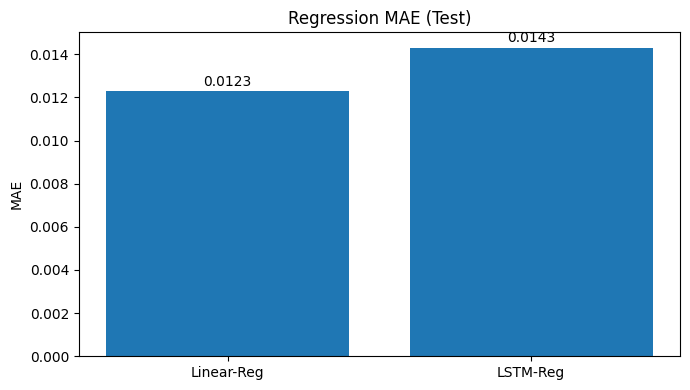

In [ ]:
import matplotlib.pyplot as plt

df_plot = summary_reg[["model","mae"]].copy()
if df_plot.empty:
    print("No regression metrics to plot.")
else:
    to_bp = False   
    y = df_plot["mae"].values * (1e4 if to_bp else 1.0)
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(df_plot["model"], y)
    ax.set_title("Regression MAE (Test)" + (" [bp]" if to_bp else ""))
    ax.set_ylabel("MAE" + (" [bp]" if to_bp else ""))
    for i, v in enumerate(y):
        if np.isfinite(v):
            ax.text(i, v*1.02 if v>=0 else v*0.98, f"{v:.4f}" if not to_bp else f"{v:.1f}", ha="center")
    fig.tight_layout()
    out_path = FIG_DIR / "summary_regression_mae.png"
    fig.savefig(out_path, dpi=150)
    print("Saved figure:", out_path.resolve())
    plt.show()
